In [1]:
# https://people.eecs.berkeley.edu/~mlustig/CS/CS_ex.pdf
# https://inst.eecs.berkeley.edu/~ee123/sp16/hw/hw9_Compressed

import numpy as np
import matplotlib.pyplot as plt

x (128,), t (128,)


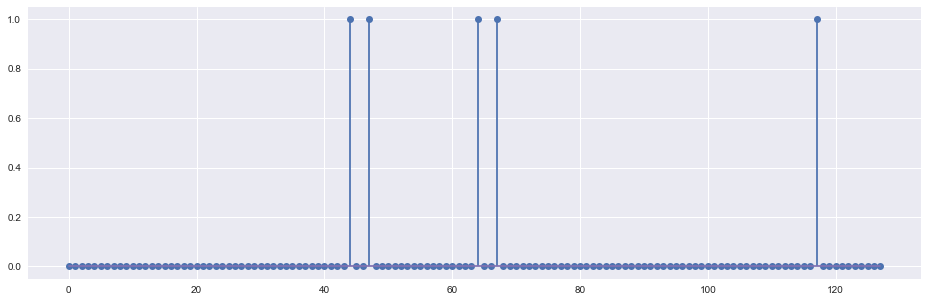

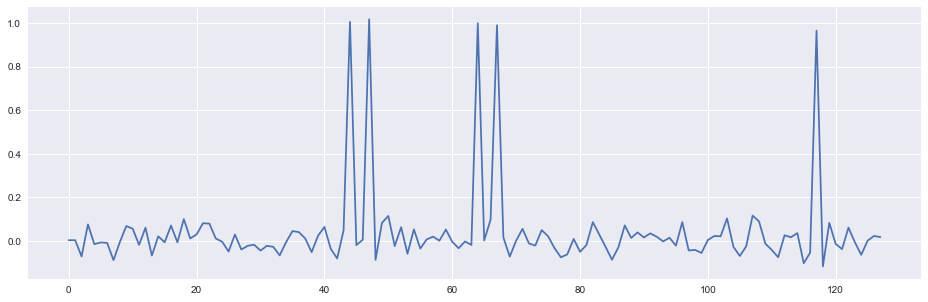

In [11]:
# Sparse Signals
N = 128  # Signal length
k = 5  # Number of non-zero components

# Construct sparse signal
t = np.arange(0, N)
x = np.zeros(N)

np.random.seed(0)
x[np.random.randint(0, N, k)] = 1  # Randomly select non-zero components
print("x {}, t {}".format(str(x.shape), str(t.shape)))

plt.figure(figsize=(16, 5))
plt.stem(t, x, use_line_collection=True)
plt.show()

# Measurement noise
y = x + 0.05 * np.random.normal(size=(N, ))

plt.figure(figsize=(16, 5))
# plt.stem(t, y, use_line_collection=True)
plt.plot(t, y)
plt.show()

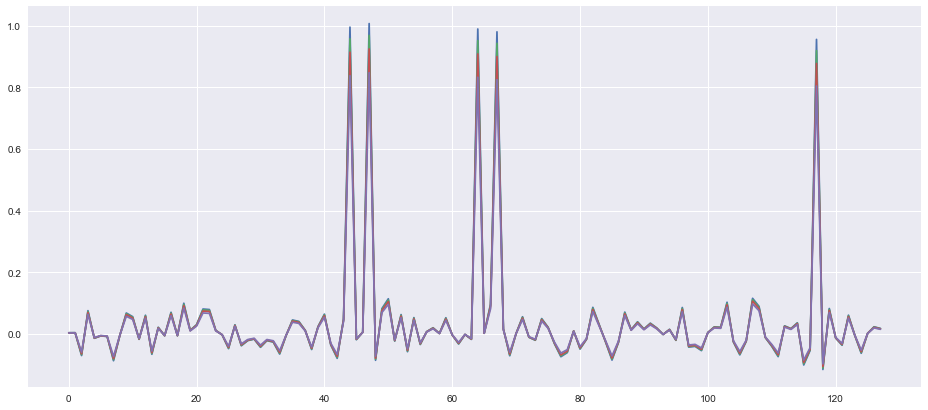

In [12]:
# Tychonov penalty
# Closed form solution

plt.figure(figsize=(16, 7))
for l in [0.01, 0.05, 0.1, 0.2]:
    x_t = 1 / (1 + l) * y
    plt.plot(t, x_t, label=str(l))
    
plt.show()

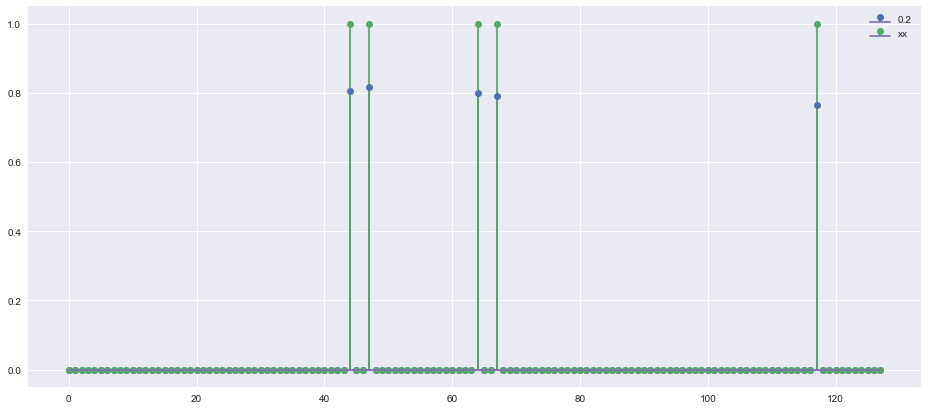

In [13]:
# L1 regularization
# Closed form solution by thresholding
def soft_threshold(y, l):
    x = y.copy()
    x[np.less(np.abs(y), l)] = 0
    x[np.less(y, -l)] = x[np.less(y, -l)] + l
    x[np.greater(y, l)] = x[np.greater(y, l)] - l
    return x


plt.figure(figsize=(16, 7))
# for l in [0.01, 0.05, 0.1, 0.2]:
for l in [0.2]:
    x_l1 = soft_threshold(y, l)

    
    plt.stem(t, x_l1, label=str(l), use_line_collection=True)
    
plt.stem(t, x, label="xx", use_line_collection=True, linefmt="C1-", markerfmt="C1o")
plt.legend()
plt.show()

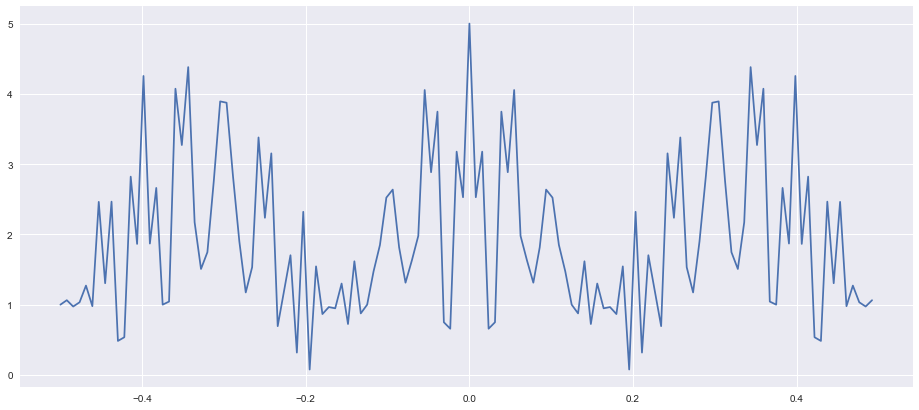

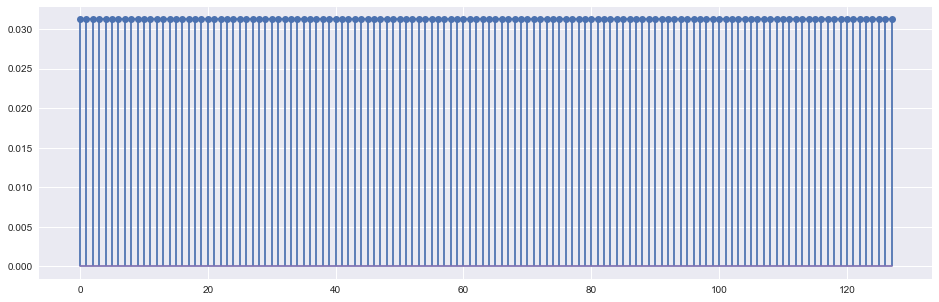

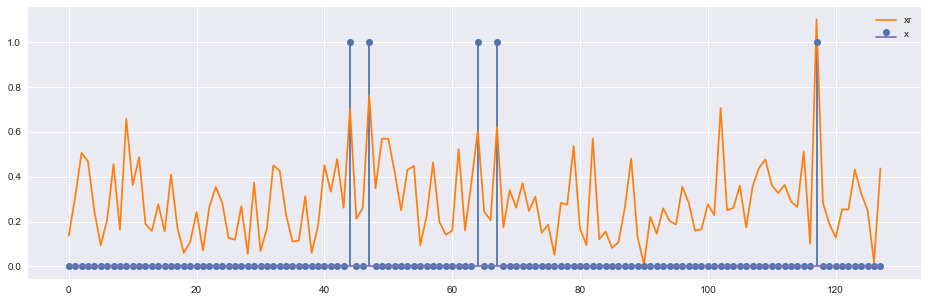

In [14]:
def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    F = np.power(np.exp( - 2 * np.pi * 1j / N), i * j )
    return F
F = DFT_matrix(N)  # 128x128 DFT Matrix

# Random Frequency Domain Sampling and Aliasing
X = np.fft.fftshift(np.fft.fft(x))
# X = np.fft.fftshift(np.matmul(F, x))

plt.figure(figsize=(16, 7))
plt.plot(np.fft.fftshift(np.fft.fftfreq(N, d=1)), np.abs(X), label="A")
plt.show()


# Undersampling (Factor 4)
Xu = np.zeros_like(X)
Xu[0:4:N] = X[0:4:N]

# L2 Recovery
Xu = np.fft.ifftshift(Xu)
xu = 4 * np.fft.ifft(Xu)
xu = np.abs(xu)

plt.figure(figsize=(16, 5))
plt.stem(t, xu, label="xu", use_line_collection=True)
plt.plot(t, xu)
plt.show()

# Random Recovery
Xr = np.zeros_like(X)
r_idx = np.random.randint(0, N, N // 4)
Xr[r_idx] = X[r_idx]

# L2 Recovery
Xr = np.fft.ifftshift(Xr)
xr = 4 * np.fft.ifft(Xr)
xr = np.abs(xr)

plt.figure(figsize=(16, 5))
plt.plot(t, xr, label="xr", c="tab:orange")
plt.stem(t, x, label="x", use_line_collection=True)
plt.legend()
plt.show()

F (128, 128), Fu (32, 128)
0 ... 1 ... 2 ... 3 ... 4 ... 5 ... 6 ... 7 ... 8 ... 9 ... 10 ... 11 ... 12 ... 13 ... 14 ... 15 ... 16 ... 17 ... 18 ... 19 ... 20 ... 21 ... 22 ... 23 ... 24 ... 25 ... 26 ... 27 ... 28 ... 29 ... 30 ... 31 ... 32 ... 33 ... 34 ... 35 ... 36 ... 37 ... 38 ... 39 ... 40 ... 41 ... 42 ... 43 ... 44 ... 45 ... 46 ... 47 ... 48 ... 49 ... 50 ... 51 ... 52 ... 53 ... 54 ... 55 ... 56 ... 57 ... 58 ... 59 ... 60 ... 61 ... 62 ... 63 ... 64 ... 65 ... 66 ... 67 ... 68 ... 69 ... 70 ... 71 ... 72 ... 73 ... 74 ... 75 ... 76 ... 77 ... 78 ... 79 ... 80 ... 81 ... 82 ... 83 ... 84 ... 85 ... 86 ... 87 ... 88 ... 89 ... 90 ... 91 ... 92 ... 93 ... 94 ... 95 ... 96 ... 97 ... 98 ... 99 ... 

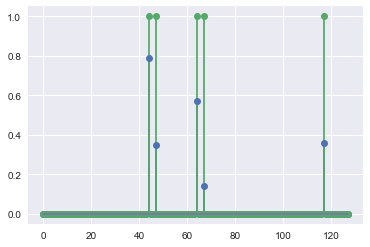

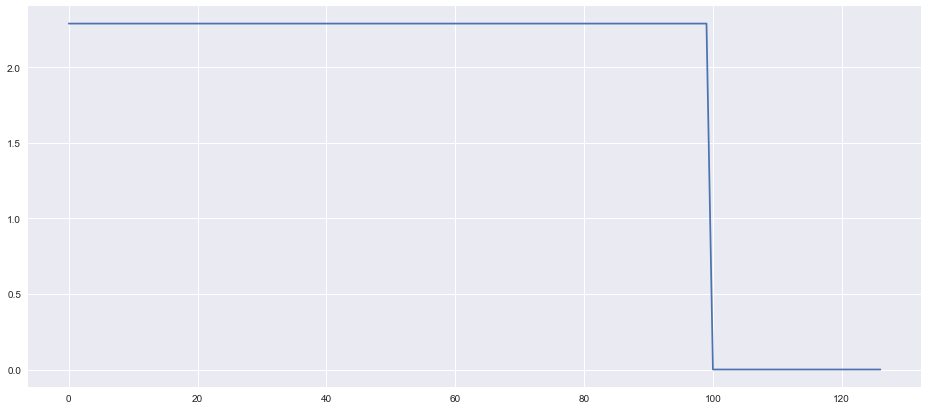

In [15]:
# Reconstruction from randomly sampled frequency domain data
def soft_threshold(x, l):
    x = x.copy()
    x[np.less_equal(np.abs(y), l)] = 0
    idx = np.greater(np.abs(y), l)
    x[idx] = x[idx] * (np.abs(x[idx] - l)) / np.abs(x[idx])
    return x


r_idx = np.random.randint(0, N, N // 4)
Fu = F[r_idx, :]
print("F {}, Fu {}".format(str(F.shape), str(Fu.shape)))

Y = np.matmul(Fu, x)  # Measurements 


# Iterative reconstruction
l = 0.5
Xi = Y  # Initialize

D = np.zeros(N-1)
for idx in range(100):
    print(idx, "...", end=" ")
    
    # Inverse DFT
    xi = np.matmul(Fu.T, Xi) / (N // 4)
    
    # Soft Threshold
    xi = soft_threshold(xi, l)
    
    # DFT
    Xi = np.matmul(Fu, xi)
    
    # Enforce data consistency
    Xi = Xi * np.equal(Y, 0.0) + Y
    
    D[idx] = np.linalg.norm(x - xi)


# Recovered signal
plt.figure()
plt.stem(t, np.abs(xi), use_line_collection=True)
plt.stem(t, x, markerfmt="C1o", linefmt="C1-", use_line_collection=True)
plt.show()

plt.figure(figsize=(16, 7))
plt.plot(D)
plt.show()

5.000000000000259


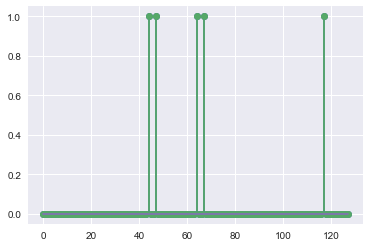

In [16]:
# Basis pursuit - Noiseless recovery
import cvxpy as cp

np.random.seed(0)
m = N // 4  # Number of measurements
r_idx = np.random.randint(0, N, m)

# Sparse basis
Fu = F[r_idx, :]

b = np.matmul(Fu, x)

# argmin |a| s.t. Fu * a = b 

a = cp.Variable(N)  # Nx1, sparse solution
objective = cp.Minimize(cp.norm1(a))  # L1 Relaxation
constraints = [Fu @ a - b == 0] 
prob = cp.Problem(objective, constraints)

print(prob.solve())

# Recovered signal
plt.figure()
plt.stem(t, a.value, use_line_collection=True)
plt.stem(t, x, markerfmt="C1o", linefmt="C1-", use_line_collection=True)
plt.show()

4.992629006588198


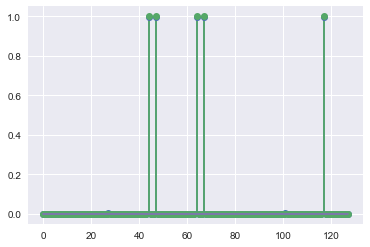

In [17]:
# Basis pursuit - Noisy recovery
import cvxpy as cp

np.random.seed(1)
m = N // 4  # Number of measurements
m = 128
r_idx = np.random.randint(0, N, m)

# Sparse basis
Fu = F[r_idx, :]
Fu = F

b = np.matmul(Fu, x)  # Frequency measurements
n = 0.05 * np.random.randn(b.shape[0]) # Noise signal
b = b + n 

# argmin |a| s.t. ||Fu * a - b|| < eps 

a = cp.Variable(N)  # Nx1, sparse solution
objective = cp.Minimize(cp.norm1(a))  # L1 Relaxation
constraints = [cp.norm2(Fu @ a - b) <= 0.5] 
prob = cp.Problem(objective, constraints)

prob.solve(verbose=False)

print(prob.value)
# print(a.value)

# Recovered signal
plt.figure()
plt.stem(t, a.value, use_line_collection=True)
# plt.plot(t, a.value)
plt.stem(t, x, markerfmt="C1o", linefmt="C1-", use_line_collection=True)
plt.show()

In [18]:
# https://sporco.readthedocs.io/en/latest/examples/dl/bpdndl.html
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_omp.html

37
235
255
140
72
(256,) (100,) (100,)
[37, 72, 140, 235, 255] [ 37  72 140 235 255]


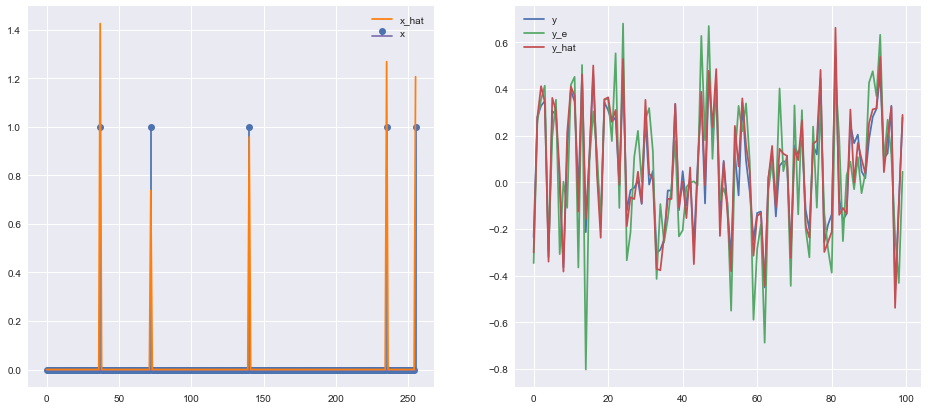

In [23]:
# Matching Pursuit
import scipy.linalg as la
"""
    x: s-sparse signal (n, )
    y: Observed signal (m, )
    e: Additive measurement noise (m, )
    A: Measurement matrix (m, n)
"""

def mp(y_, A_, s_):
    r = y_.copy()  # r_0
    a = np.zeros_like(y_)  # (m, )
    x_hat = np.zeros(A_.shape[1])  # (n, )
    idx = []
    
    for i in range(s_):
        dot = np.dot(r.T, A_)  # (n, )
        j = np.argmax(np.abs(dot))  # Best approximation of current residual ()
        idx.append(j)
        print(j)
        
        x_hat[j] = dot[j]  # Estimate of x
        
        a = A_ @ x_hat  # New measurement approximation
        r = y_.copy() - a  # Residual
    
    return x_hat, a, r, idx


n = 256
m = 100
s = 5
t = np.arange(0, n)
x = np.zeros(n)

np.random.seed(1)
idx = np.random.randint(0, n, s)
x[idx] = 1  # Randomly select non-zero components

A = np.random.randn(m, n) # Random normal matrix
# F = scipy.linalg.dft(n)  # Undersampled DFT Matrix
# F = la.dft(n)
# A = F[np.random.randint(0, n, m), :]


A = A / np.linalg.norm(A, axis=0) # Normalize
y = A @ x
e = 0.2 * np.random.normal(size=(m, ))


# MP
x_hat, y_hat, r, idx_hat = mp(y + e, A, s)
print(x_hat.shape, y_hat.shape, r.shape)

idx.sort()
idx_hat.sort()
print(idx_hat, idx)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].stem(t, x, label="x", use_line_collection=True)
ax[0].plot(t, x_hat, label="x_hat", c="tab:orange")
# ax[0].stem(t, x_hat, label="x_hat", use_line_collection=True)
ax[0].legend()

ax[1].plot(y, label="y")
ax[1].plot(y + e, label="y_e")
ax[1].plot(y_hat, label="y_hat")
ax[1].legend()
plt.show()